# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
from scipy.stats import multivariate_normal as mvn
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

from copy import deepcopy
from sys import stdout


# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("../files/hw2_out.csv", sep="\t", header=0, index_col="user_id")
x = data_df.values

print x #посмотрим, что есть в x

[[ 0.36632415  0.5141847   0.62212837 ...,  0.69230769  0.575       0.66666667]
 [ 0.29887335  0.5426442   0.47887675 ...,  0.76923077  0.6875      0.66666667]
 [ 0.41614712  0.52530401  0.67350951 ...,  0.84615385  0.          0.55555556]
 ..., 
 [ 0.38821747  0.48734326  0.62007002 ...,  0.76923077  0.06875     0.77777778]
 [ 0.57969141  0.52809191  0.66311873 ...,  0.92307692  0.81875     0.55555556]
 [ 0.30656756  0.39174244  0.34964929 ...,  0.69230769  0.21875     0.88888889]]


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("s.feldsherov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [36]:
class Clustering_gaussian_mixture:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        self.k = kwargs['k']
        self.max_steps = kwargs.get('max_steps', 200) #считаем, что за 200 шагов всегда достаточно хорошо сойдемся, можно задать количество шагов
        assert(self.max_steps > 1)
        assert(self.k >= 1)
        return
        
    def fit(self, x, y=None):
        self.x_len = len(x)
        self.features_len = len(x[0])
        
        mu = np.array([x[i] for i in np.random.choice(self.x_len, self.k, replace=False)]) #начальные условия для ЕМ
        cv = np.zeros(self.features_len**2).reshape((self.features_len, self.features_len))
        for i in range(self.features_len): cv[i][i] = 1
        cov_m = [deepcopy(cv) for i in range(self.k)]
        p_k = np.array([1.0 / self.k] * self.k)
        distr = [mvn(mu[i], cov_m[i], allow_singular=True) for i in range(self.k)]
        gamma = None
        likelihood = None
        
        for step in range(self.max_steps):
            #E step
            gamma_new = np.zeros(self.k * self.x_len).reshape((self.k, self.x_len))
                
            for nn in range(self.x_len):
                den = 0
                for j in range(self.k):
                    den += p_k[j] * distr[j].pdf(x[nn])
                for i in range(self.k):
                    gamma_new[i][nn] =  p_k[i]*distr[i].pdf(x[nn]) / den
            
            new_likelihood = 0
            for nn in range(self.x_len):
                tp = 0
                for j in range(self.k):
                    tp += p_k[j]*distr[j].pdf(x[nn])
                new_likelihood += np.log(tp)
            
            if gamma is not None and np.max(gamma - gamma_new) < 1e-3: #если уже хорошо сошлись, то можно заканчивать
                break
                
            if likelihood is not None and abs(new_likelihood - likelihood) < 1e-3:
                break
            
            likelihood = new_likelihood
            gamma = gamma_new
             
            #M step
            N_k = np.array([gamma[i].sum() for i in range(self.k)])
            mu_new = np.zeros(self.k*self.features_len).reshape((self.k, self.features_len))
            
            for nn in range(self.x_len):
                for ck in range(self.k):
                    mu_new[ck] += x[nn]*gamma[ck][nn]
            for ck in range(self.k):
                mu_new[ck] /= N_k[ck]
                
            cov_m_new = [np.zeros(self.features_len**2).reshape((self.features_len, self.features_len)) for i in range(self.k)]
            
            for ck in range(self.k):
                for nn in range(self.x_len):
                    for i in range(self.features_len):
                        for j in range(self.features_len):
                            dif = (x[nn] - mu_new[ck])
                            cov_m_new[ck][i][j] += gamma[ck][nn]/N_k[ck] * dif[i] * dif[j]
                            
            mu = mu_new
            cov_m = cov_m_new
            p_k = N_k / self.x_len
            distr = [mvn(mu[i], cov_m[i], allow_singular=True) for i in range(self.k)]
            
        self.last_steps = step
        self.gamma = gamma
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return [max(map(lambda x: (x[1], x[0]), enumerate(self.gamma[:, el])))[1] for el in xrange(self.x_len)]
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

In [37]:
class Clustering_kmeans:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):
        self.k = kwargs['k']
        self.max_steps = kwargs.get('max_steps', 200) #считаем, что за 200 шагов всегда достаточно хорошо сойдемся, можно задать количество шагов
        assert(self.max_steps > 1)
        assert(self.k >= 1)
        return
        
    def fit(self, x, y=None):
        self.x_len = len(x)
        self.features_len = len(x[0])
        
        centroids = np.array([x[i] for i in np.random.choice(self.x_len, self.k, replace=False)]) #инициализируем кластеры
        old_clasters = None
        
        for step in range(self.max_steps): 
            clasters = np.zeros(self.x_len)
            for el in xrange(self.x_len):
                pos = min(map(lambda ell: (np.sum((x[el] - ell[1])**2), ell[0]), enumerate(centroids)))
                clasters[el] = pos[1]
            
            if old_clasters is not None and np.array_equal(clasters, old_clasters): #алгоритм сошелся
                break
                
            centroids = np.zeros(self.k*self.features_len).reshape((self.k, self.features_len))
            cnts = np.zeros(self.k)
            
            for i, clst in enumerate(clasters):
                centroids[clst] += x[i]
                cnts[clst] += 1
            
            for i in range(self.k):
                centroids[i] /= cnts[i]
            
            old_clasters = clasters
        
        self.last_steps = step
        self.centroids = centroids
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return [min(map(lambda ell: (np.sum((x[el] - ell[1])**2), ell[0]), enumerate(self.centroids)))[1]
                for el in xrange(self.x_len)]
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

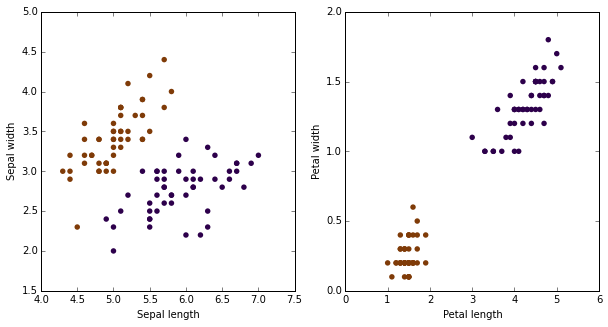

In [38]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [39]:
EM_GM = Clustering_gaussian_mixture(k=2)
KMeans = Clustering_kmeans(k=2)
pred_iris_kmeans = KMeans.fit_predict(x_iris)
pred_iris_GM = EM_GM.fit_predict(x_iris)

print "EM steps: %d \nkmeans steps %d:" % (EM_GM.last_steps, KMeans.last_steps)

print "Adjusted Rand index kmeans for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris_kmeans)
print "Adjusted Rand index GM for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris_GM)

EM steps: 11 
kmeans steps 3:
Adjusted Rand index kmeans for iris is: 1.00
Adjusted Rand index GM for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [40]:
def quality_inertia(x, y):
    k = np.max(y) + 1
    features_len = len(x[0])
    centroids = np.zeros(k*features_len).reshape((k, features_len))
    cnts = np.zeros(k)
    
    for i, clst in enumerate(y):
        centroids[clst] += x[i]
        cnts[clst] += 1
    
    for i in range(k):
        centroids[i] /= cnts[i]
        
    inertia = 0
    
    for i, el in enumerate(x):
        inertia += np.sum((el - centroids[y[i]])**2)
    
    return inertia

def quality_mean_rad(x, y):
    k = np.max(y) + 1
    features_len = len(x[0])
    centroids = np.zeros(k*features_len).reshape((k, features_len))
    cnts = np.zeros(k)
    
    for i, clst in enumerate(y):
        centroids[clst] += x[i]
        cnts[clst] += 1
    
    for i in range(k):
        centroids[i] /= cnts[i]
    
    rad = [0.] * k
    for i, el in enumerate(x):
        rad[y[i]] = max(rad[y[i]], np.sqrt(np.sum((el - centroids[y[i]])**2)))
    
    return np.mean(rad)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Текущий шаг: 1
	Start EM
	Start kmeans
	EM steps: 1 
 	kmeans steps 1
Текущий шаг: 2
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 10
Текущий шаг: 3
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 24
Текущий шаг: 4
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 5
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 6
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 7
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 8
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 9
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 10
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 11
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 12
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 13
	Start EM
	Start kmeans
	EM steps: 29 
 	kmeans steps 29
Текущий шаг: 14
	Start EM
	Start kmeans
	EM steps: 29 
 	kmean

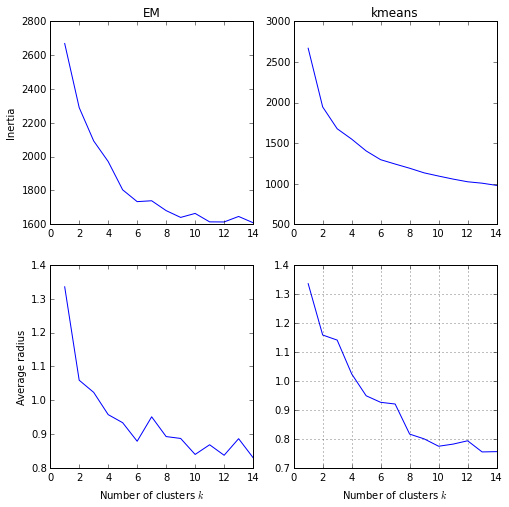

In [41]:
ks = range(1, 15)
criteria_inert_gm = np.zeros(len(ks))
criteria_inert_km = np.zeros(len(ks))
criteria_rad_gm = np.zeros(len(ks))
criteria_rad_km = np.zeros(len(ks))


for i, k in enumerate(ks):
    print "Текущий шаг: %d" % k
    EM_GM = Clustering_gaussian_mixture(k=k, max_steps=30)
    KMeans = Clustering_kmeans(k=k, max_steps=30)

    print "\tStart EM"
    y = EM_GM.fit_predict(x)
    criteria_inert_gm[i] = quality_inertia(x, y)
    criteria_rad_gm[i] = quality_mean_rad(x, y)
    
    print "\tStart kmeans"
    y = KMeans.fit_predict(x)
    criteria_inert_km[i] = quality_inertia(x, y)
    criteria_rad_km[i] = quality_mean_rad(x, y)
    print "\tEM steps: %d \n \tkmeans steps %d" % (EM_GM.last_steps, KMeans.last_steps)
    
    
pl.figure(figsize=(8, 6))
fig, ax = pl.subplots(2, 2, squeeze=True)
fig.set_size_inches((8, 8))
ax[0][0].plot(ks, criteria_inert_gm)
ax[0][0].set_title("EM")
ax[0][0].set_ylabel("Inertia")
ax[0][1].plot(ks, criteria_inert_km)
ax[0][1].set_title("kmeans")

ax[1][0].plot(ks, criteria_rad_gm)
ax[1][0].set_ylabel("Average radius")
ax[1][0].set_xlabel("Number of clusters $k$")
ax[1][1].plot(ks, criteria_rad_km)
ax[1][1].set_xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [42]:
k = 7
cls = Clustering_gaussian_mixture(k=k, max_steps=179)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 7958
[t-SNE] Computed conditional probabilities for sample 2000 / 7958
[t-SNE] Computed conditional probabilities for sample 3000 / 7958
[t-SNE] Computed conditional probabilities for sample 4000 / 7958
[t-SNE] Computed conditional probabilities for sample 5000 / 7958
[t-SNE] Computed conditional probabilities for sample 6000 / 7958
[t-SNE] Computed conditional probabilities for sample 7000 / 7958
[t-SNE] Computed conditional probabilities for sample 7958 / 7958
[t-SNE] Mean sigma: 0.108164
[t-SNE] Error after 83 iterations with early exaggeration: 22.155751
[t-SNE] Error after 322 iterations: 3.241215


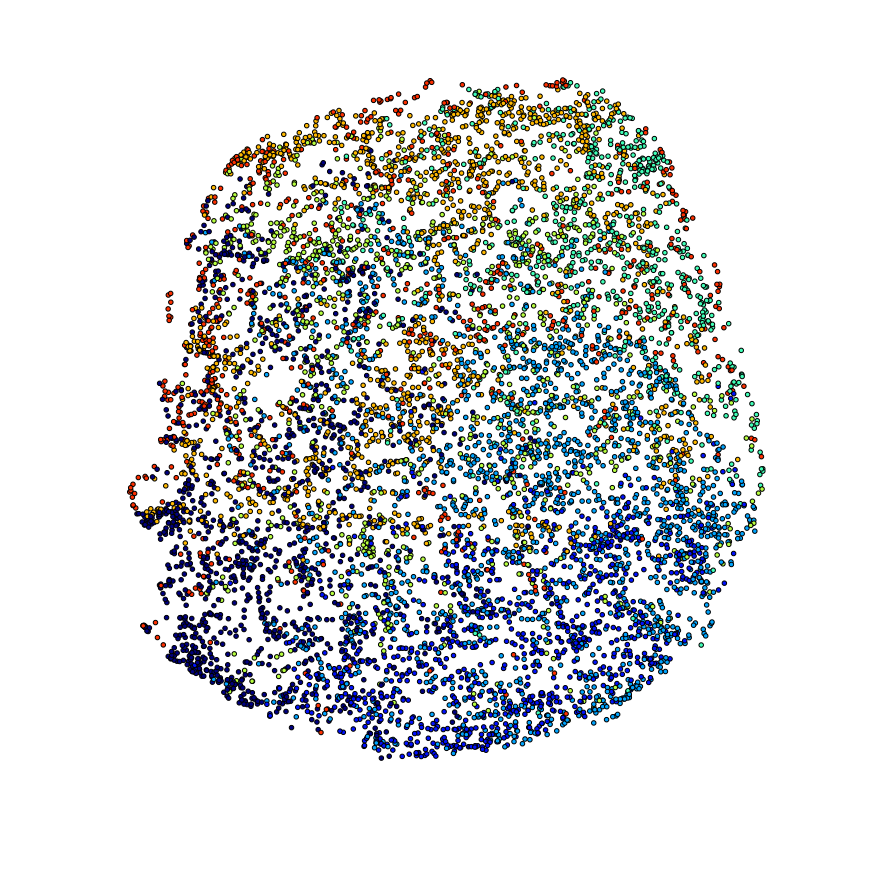

In [43]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

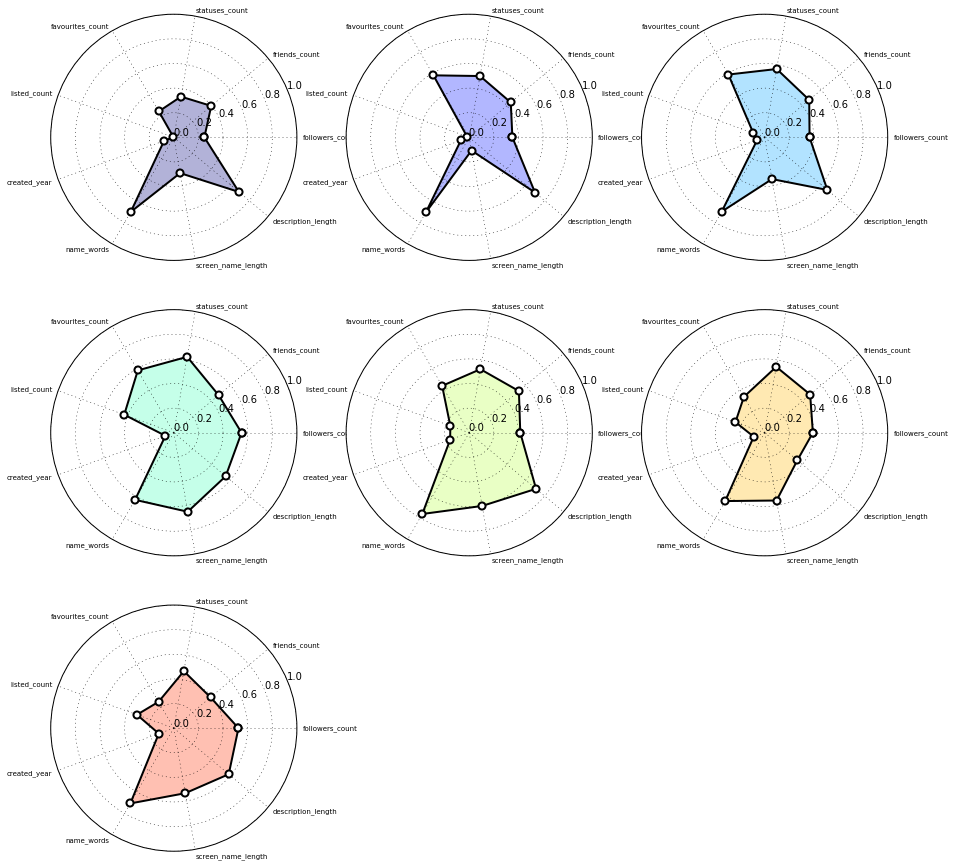

In [44]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.